<a href="https://colab.research.google.com/github/Mohamed-Harish-M-123/Capstone-Project-III/blob/main/Coronavirus_Tweets_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Project Name: Coronavirus Tweets Sentiment Analysis**
####**Project Type:** Machine Learning - Classification
####**Contribution:** Individual
####**Name:** MOHAMED HARISH


##**GitHub Link:** https://github.com/Mohamed-Harish-M-123/Capstone-Project-III

## **Business context:**
####This challenge asks you to build a classification model to predict the sentiment of covid-19 tweets. The tweets have been pulled from Twitter and manual tagging has been done then. The names and usernames have been given codes to avoid any privacy concerns.

##**Problem statement:**
####In the context of analyzing COVID-19 tweets, the task is to develop a sentiment classification model that accurately predicts the sentiment expressed in these tweets. Manual tagging has been performed on the tweets to assign sentiment labels. However, due to the vast amount of data generated on social media platforms like Twitter, manual analysis becomes time-consuming and inefficient. Therefore, there is a need to automate the sentiment analysis process for COVID-19 tweets to provide timely insights and understand public sentiment during the pandemic.
####The challenge lies in building a robust and accurate classification model that can handle the nuances of the language used in these tweets, account for privacy concerns by encoding names and usernames, and effectively classify tweets into positive, negative, or neutral sentiment categories.
####The successful development of such a model will enable organizations to gain real-time insights into public sentiment regarding COVID-19, allowing them to make informed decisions and respond effectively to public concerns and needs.

##Importing libraries:

In [1]:
# Here we'll import the required libraries for this project

from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix,classification_report

##Now let's load our dataset in this notebook 

In [2]:
# Mount the drive and read the csv file which is our dataset
drive.mount("/content/drive")

path = "/content/drive/MyDrive/dataset/Coronavirus Tweets.csv"

df = pd.read_csv(path, encoding='latin-1')

Mounted at /content/drive


In [3]:
# View the dataset

df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive


In [4]:
# Check the info of our dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
# Checking null values

df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [6]:
# Check if any duplicates present

print("Duplicated records present in our dataset is ", df.duplicated().sum())

Duplicated records present in our dataset is  0


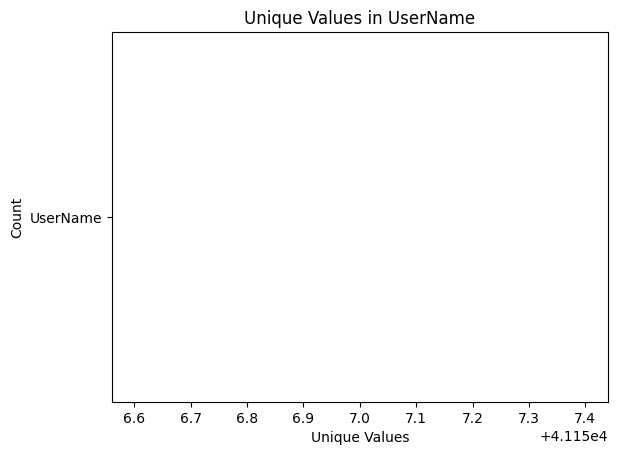

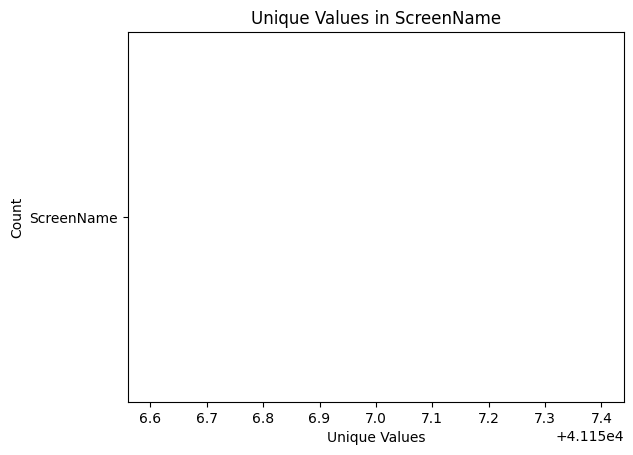

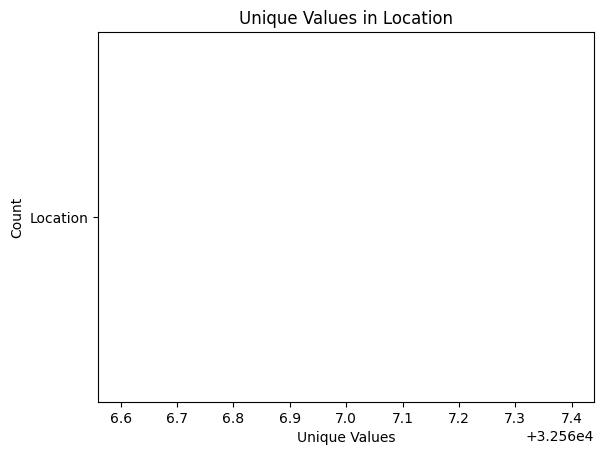

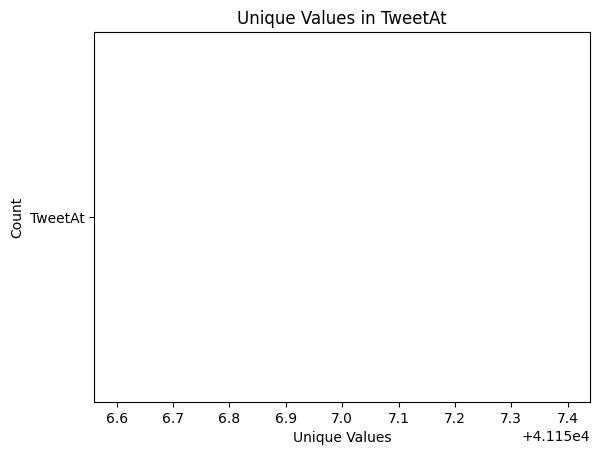

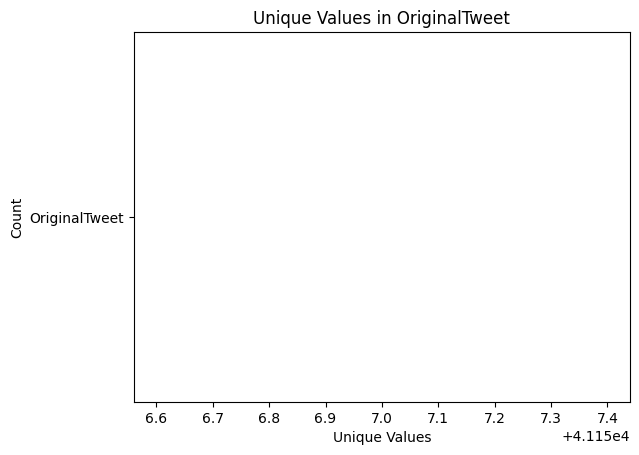

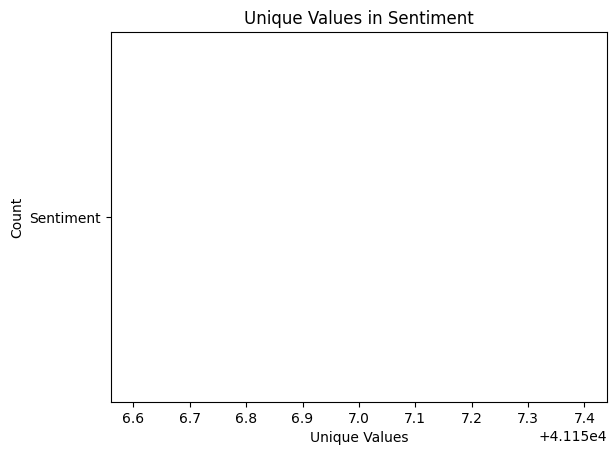

In [33]:
# Iterate over each column and plot unique value counts
for column in df.columns:
    unique_values = df[column].unique()
    value_counts = df[column].value_counts().sum()
    
    # Create a bar plot
    plt.figure()
    plt.bar(value_counts, column)
    plt.xlabel('Unique Values')
    plt.ylabel('Count')
    plt.title(f'Unique Values in {column}')
    plt.show()

###Dataset overview:
* Dataset has 6 features in total. 2 Numerical and 4 Categorical features.
* Column Location has 8590 null values.
* No duplicated records in the dataset.

## Let's start with the Exploratory Data Analysis (EDA)

In [7]:
# Before proceeding, lets take a copy of our original dataset for further processing.

tweets_df = df.copy()


In [8]:
# Change the 'TweetAt' column datatype from object to datatime datatype

tweets_df['TweetAt'] = pd.to_datetime(tweets_df['TweetAt'])
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


<ipython-input-8-b8e62f27c1f4>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  tweets_df['TweetAt'] = pd.to_datetime(tweets_df['TweetAt'])


In [9]:
# Extracting the day and month from the 'TweetAt' column

tweets_df['tweeted_day'] = tweets_df['TweetAt'].dt.day_name()
tweets_df['tweeted_month'] = tweets_df['TweetAt'].dt.month_name()

tweets_df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,tweeted_day,tweeted_month
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Monday,March
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,Monday,March
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,Monday,March


Text(0.5, 1.0, 'Most tweets - Location')

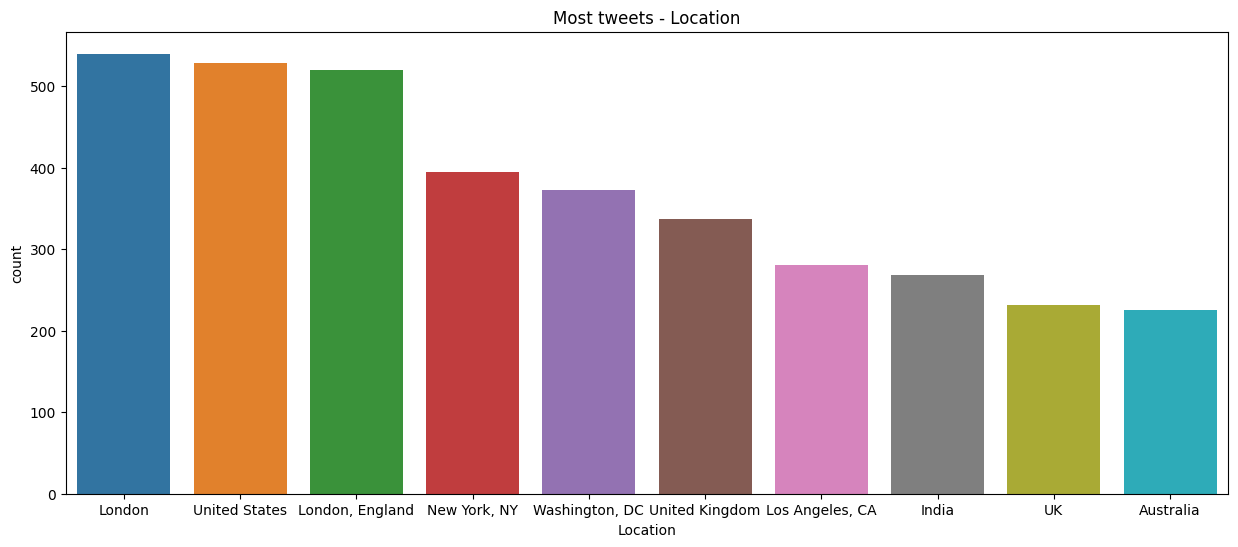

In [10]:
# Lets check the top 10 tweeted location in our dataset

top_tweeted_location = tweets_df['Location'].value_counts().sort_values(ascending=False)[:10]

# Visualize the above insight

plt.figure(figsize=(15,6))
sns.countplot(x='Location',data=tweets_df[tweets_df['Location'].isin(top_tweeted_location.index)],order=top_tweeted_location.index)
plt.title('Most tweets - Location')

Text(0.5, 1.0, 'Most tweets - Month')

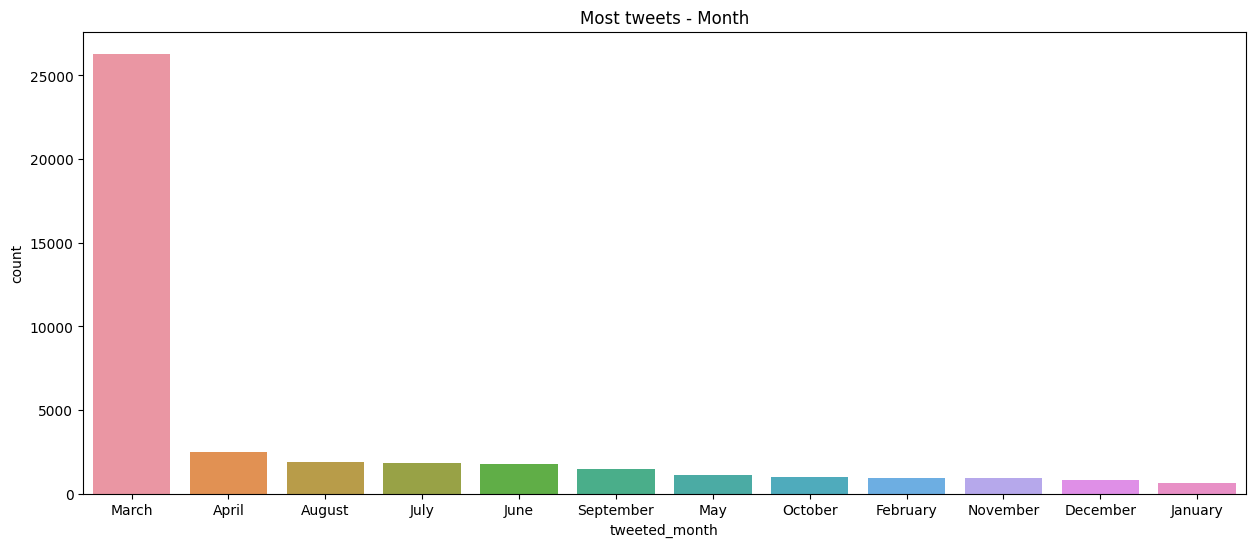

In [11]:
# Checking with the 'tweeted_month' column.

plt.figure(figsize=(15,6))
sns.countplot(data=tweets_df, x='tweeted_month', order=tweets_df['tweeted_month'].value_counts(ascending=False).index)
plt.title('Most tweets - Month')

Text(0.5, 1.0, 'Most tweets - Day')

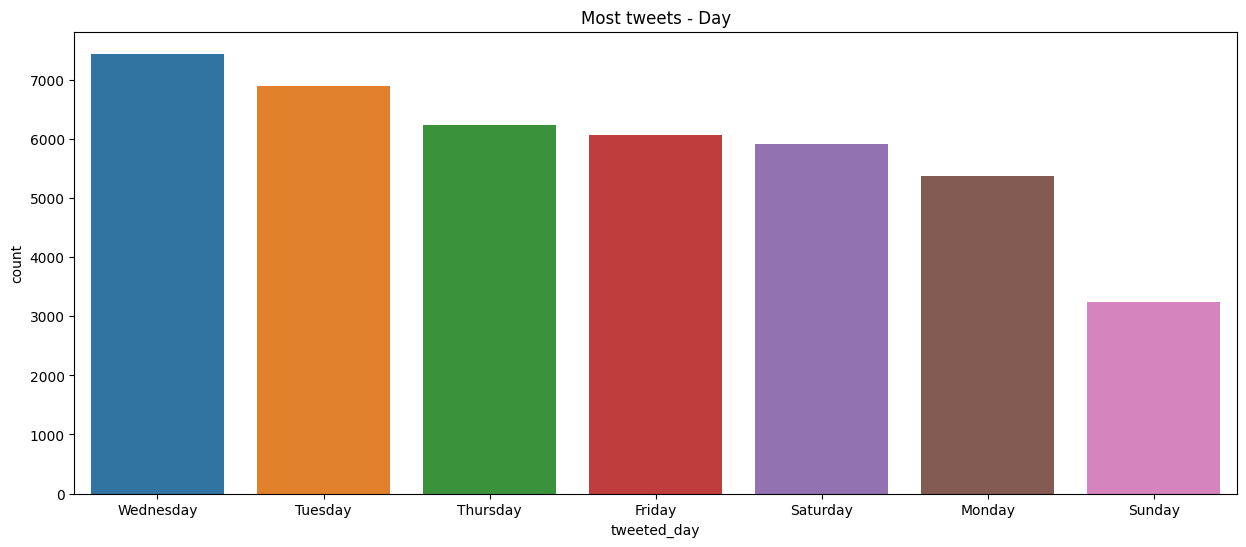

In [12]:
# Checking with the 'tweeted_day' column.

plt.figure(figsize=(15,6))
sns.countplot(data=tweets_df, x='tweeted_day', order=tweets_df['tweeted_day'].value_counts(ascending=False).index)
plt.title('Most tweets - Day')

In [13]:
tf = tweets_df['Sentiment'].value_counts()
tf

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

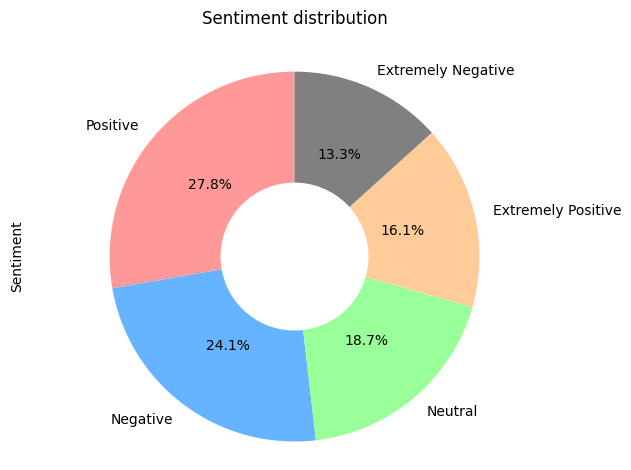

In [14]:
# Visualize the 'sentiment' column by donut chart 

fig,ax = plt.subplots()

# specify colurs in hex values 
colors1 = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#808080']

# Plot the pie
tweets_df['Sentiment'].value_counts().plot(kind='pie',autopct='%1.1f%%', colors = colors1 ,startangle=90)

#draw centre circle
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.title('Sentiment distribution\n')  
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Tweet Response Timeline'}, xlabel='TweetAt'>

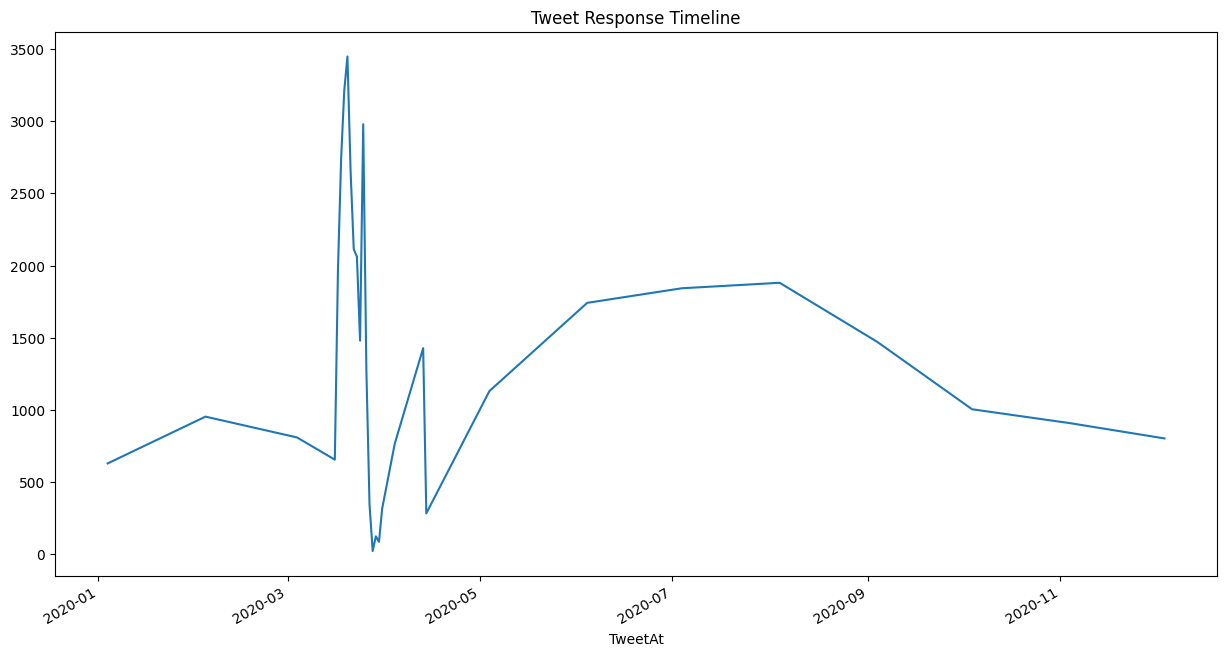

In [15]:
# Visualize the tweets timeline
plt.figure(figsize=(15,8))
tweet_timeline=tweets_df.groupby('TweetAt').count().sort_values(by='TweetAt')['OriginalTweet']
plt.title('Tweet Response Timeline')
tweet_timeline.plot()